# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import numpy as np
from dotenv import load_dotenv
import utils

Load the cleaned data from csv file and the code dictionary for the column names.

In [2]:
_,_,_,nsamples = utils.getVars()
datadir  = os.path.join(os.getcwd(),"small_data")
fname    = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '.csv')
df       = pd.read_csv(fname,low_memory=False)
fname = os.path.join(datadir,str(nsamples) + 'targets_oi.csv')
targ_oi  = pd.read_csv(fname)
codedict = utils.getCodeDictionary()
target   = targ_oi['healthcodes'][1]
df

,Unnamed: 0,index,HHLANP,FBATHP,DRIVESP,WGTP23,WGTP22,WGTP25,WGTP24,FWATP,...,FOD1P,FMARP,SOCP,FSMOCP,FDOUTP,PERNP,SCH,TEL,TEN,STATE
0,0,12798,9500,0,0,456,284,357,362,0,...,1099,0,-1,0,1,0,1,1,1,AL
1,1,38926,2575,0,1,23,71,119,104,0,...,1099,0,395011,1,0,60000,1,1,1,AL
2,2,39892,9500,0,1,60,9,37,34,0,...,1099,0,259040,1,0,5000,1,1,1,AL
3,3,17828,9500,0,0,43,50,80,12,0,...,1099,0,-1,0,0,0,1,1,3,AL
4,4,40052,9500,0,1,48,27,8,7,0,...,5200,0,1110XX,0,0,75000,1,1,4,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,10195,4566,9500,0,0,19,43,8,7,1,...,6201,1,252030,1,1,66000,1,1,1,WY
10196,10196,2400,9500,0,0,85,59,89,75,0,...,1099,0,-1,1,0,-10001,2,1,1,WY
10197,10197,749,9500,0,0,49,48,80,16,0,...,1099,0,434051,0,0,0,1,1,1,WY
10198,10198,2594,9500,0,0,26,12,11,28,0,...,1099,0,-1,0,0,0,1,1,1,WY


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

We know that there are a number of categorical variables in the dataset, as well as numerical variables. We can use the predictive power score (pps) to estimate the predictive power of each variable for our target variable. However, to use the predictive power score, we need to convert categorical variables to data type 'category.' 

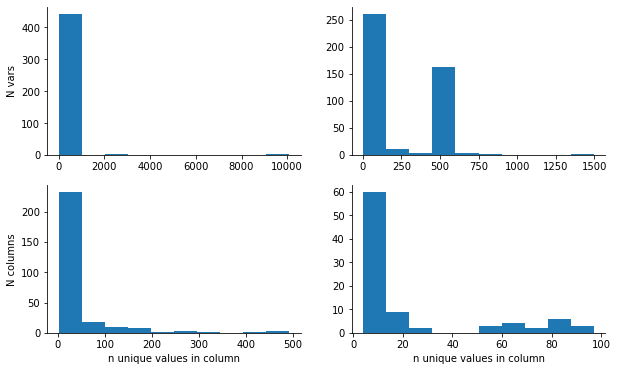

In [4]:
#try to identify categorical variables by considering number of unique values?
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.hist(df.nunique()) 
plt.ylabel('N vars')
plt.title('')
sns.despine()

plt.subplot(2,2,2)
plt.hist(df.nunique()[df.nunique().between(1,1500)])
sns.despine()

plt.subplot(2,2,3)
plt.hist(df.nunique()[df.nunique().between(1,500)])
sns.despine()
plt.xlabel('n unique values in column')
plt.ylabel('N columns')

plt.subplot(2,2,4)
plt.hist(df.nunique()[df.nunique().between(4,100)])
sns.despine()
plt.xlabel('n unique values in column')
plt.show()

In [5]:
# spot check info available for a variable that is very likely categorical (<=3 unique values)
cols = df.columns[df.nunique().between(2,3)]
dets = utils.variableDetails(cols[0])
print(dets['label'])
print('values:')
print(dets['values']['item'])

Bathtub or shower allocation flag
values:
{'1': 'Yes', '0': 'No', '-1': 'N/A (GQ)'}


In [6]:
# spot check info available for a variable that is very likely numerical (> 500 unique values)
cols = df.columns[df.nunique().gt(800)]
dets = utils.variableDetails(cols[1])
print(dets['label'])
print('values:')
print(dets['values']['item'])

Total person's income (signed, use ADJINC to adjust to constant dollars)
values:
{'-19999': 'N/A (less than 15 years old)', '-19998': 'Loss of $19998 or more (Rounded and bottom-coded components)', '0': 'None'}


We know that the index column comes from the index in the row from our api call. It is categorical and at this point we do not need it, so we can drop. 

In [7]:
df.drop('index',axis=1,inplace=True)

It looks like info on numerical values (like in the immediate cell above) includes a 'range' key to indicate the min and max of that numerical variable, while categorical variables do not include that information. Maybe we can use this to identify categorical/numerical variables. 

In [8]:
# call API for states in loop and save csv locally if it doesn't exist yet:
column_list = df.columns.tolist()
column_list.remove('STATE')
fname = os.path.join(datadir,'datatype_ncol' + str(df.shape[1]) + '.csv')
if os.path.exists(fname) == False:  
    range_key = list()
    info_from_api = list()
    n_unq_vals = list()
    for column in column_list:
        try: 
            dets = utils.variableDetails(column)
            range_key.append('range' in dets['values'].keys())
            info_from_api.append(True)
            n_unq_vals.append(df[column].nunique())
        except:
            range_key.append(False)
            info_from_api.append(False)
            n_unq_vals.append(df[column].nunique())
    datatype = pd.DataFrame({'var_name':column_list,'range_key':range_key,'n_unq_vals':n_unq_vals,'info_from_api':info_from_api})
    datatype.to_csv(fname)
else:
    print('')
    datatype = pd.read_csv(fname)

In [9]:
print('The number of columns in our main df should equal the number of rows in our datatype dataframe: ')
print('df column N:' + str(datatype.shape[1]))
print('datatype rows N:' + str(datatype.shape[0]))
print('The only vars where numerical info is not from the api:')
print(datatype[datatype.info_from_api == False]['var_name'])

The number of columns in our main df should equal the number of rows in our datatype dataframe: 
df column N:5
datatype rows N:447
The only vars where numerical info is not from the api:
334    SERIALNO
Name: var_name, dtype: object


We can do another check to see if this approach is adding up. Are there any variables coming out as categorical that have a very high number of unique values? Are any coming out as numerical that have very few unique values? 

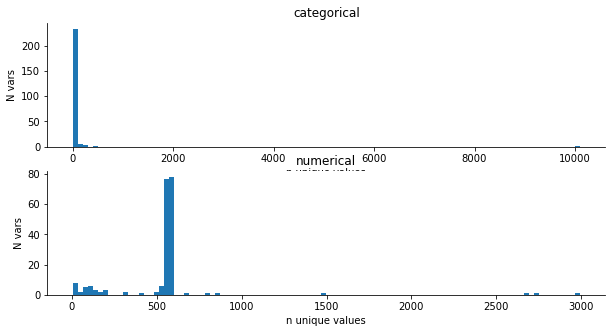

In [10]:
# now we can look at the distributions of N unique values for our columns again with our categorical/numerical labels
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==False],bins=100) 

plt.ylabel('N vars')
plt.xlabel('n unique values')
plt.title('categorical')
sns.despine()

plt.subplot(2,1,2)
plt.hist(datatype['n_unq_vals'].loc[datatype['range_key']==True],bins=100) 
plt.xlabel('n unique values')
plt.ylabel('N vars')

plt.title('numerical')
sns.despine()

plt.show()

In [11]:
# we can check our vars that lie on the unexpected extremes (low unique N, numerical):
print('var with min number of unique values that may be numerical:') 
min_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==True].idxmin()]

# get deets:
dets = utils.variableDetails(min_cat_row['var_name'])
print(dets)

var with min number of unique values that may be numerical:
{'name': 'RACNUM', 'label': 'Number of major race groups represented', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP', 'values': {'range': [{'min': '1', 'max': '6', 'description': 'Race groups'}]}}


This is numerical, so the approach may be working..

In [12]:
# we can check our vars that lie on the unexpected extremes (high unique N, categorical)::
print('var with max number of unique values that may be categorical:') 
max_cat_row = datatype.iloc[datatype['n_unq_vals'].loc[datatype['range_key']==False].idxmax()]

print(max_cat_row)

# get deets:
dets = utils.variableDetails(max_cat_row['var_name'])
print(dets)

var with max number of unique values that may be categorical:
Unnamed: 0            334
var_name         SERIALNO
range_key           False
n_unq_vals          10098
info_from_api       False
Name: 334, dtype: object
{'name': 'SERIALNO', 'label': 'Housing unit/GQ person serial number', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP'}


This one also checks out. Now we can convert the datatypes in the main df.

In [13]:
datatype.set_index('var_name',inplace=True)

In [14]:
#convert the datatypes
print('converting data types...')
for index in datatype.index:
    if datatype.loc[index].range_key == False:
        df[index] = df[index].astype('category')

converting data types...


In [15]:
df.dtypes

HHLANP     category
FBATHP     category
DRIVESP    category
WGTP23        int64
WGTP22        int64
             ...   
PERNP         int64
SCH        category
TEL        category
TEN        category
STATE        object
Length: 448, dtype: object

Now we can make a copy of 'data_all' but this time fill in columns and values with more descriptive info. Below, call the api and fill in what the codes mean for each cateogorical variable.

In [16]:
verbdf = df.copy()

In [17]:
codedict,_=utils.getCodeDictionary()
for column in df:
    if df[column].dtype == 'category':
        dets = utils.variableDetails(column)
        if 'values' in dets.keys():
            newname = codedict[column]
            mapdict = dets['values']['item']
            if type(verbdf[column][0]) == str:
                verbdf[column].replace(mapdict,inplace=True)
            else:
                newdict = {}
                for key in mapdict.keys():
                    newdict[int(key)]=mapdict[key]
            verbdf[column].replace(newdict,inplace=True)

In [18]:
df.head()

,HHLANP,FBATHP,DRIVESP,WGTP23,WGTP22,WGTP25,WGTP24,FWATP,WGTP21,WGTP20,...,FOD1P,FMARP,SOCP,FSMOCP,FDOUTP,PERNP,SCH,TEL,TEN,STATE
0,9500,0,0,456,284,357,362,0,275,430,...,1099,0,-1,0,1,0,1,1,1,AL
1,2575,0,1,23,71,119,104,0,156,27,...,1099,0,395011,1,0,60000,1,1,1,AL
2,9500,0,1,60,9,37,34,0,33,33,...,1099,0,259040,1,0,5000,1,1,1,AL
3,9500,0,0,43,50,80,12,0,54,53,...,1099,0,-1,0,0,0,1,1,3,AL
4,9500,0,1,48,27,8,7,0,21,19,...,5200,0,1110XX,0,0,75000,1,1,4,AL


In [19]:
verbdf.head()

,HHLANP,FBATHP,DRIVESP,WGTP23,WGTP22,WGTP25,WGTP24,FWATP,WGTP21,WGTP20,...,FOD1P,FMARP,SOCP,FSMOCP,FDOUTP,PERNP,SCH,TEL,TEN,STATE
0,English only household,No,N/A (Nonworker or worker who does not drive to...,456,284,357,362,No,275,430,...,N/A (less than bachelor's degree),No,N/A (less than 16 years old/NILF who last work...,No,Yes,0,"No, has not attended in the last 3 months",Yes,Owned with mortgage or loan (include home equi...,AL
1,Korean,No,1.000 vehicles (Drove alone),23,71,119,104,No,156,27,...,N/A (less than bachelor's degree),No,PRS-Barbers,Yes,No,60000,"No, has not attended in the last 3 months",Yes,Owned with mortgage or loan (include home equi...,AL
2,English only household,No,1.000 vehicles (Drove alone),60,9,37,34,No,33,33,...,N/A (less than bachelor's degree),No,EDU-Teaching Assistants,Yes,No,5000,"No, has not attended in the last 3 months",Yes,Owned with mortgage or loan (include home equi...,AL
3,English only household,No,N/A (Nonworker or worker who does not drive to...,43,50,80,12,No,54,53,...,N/A (less than bachelor's degree),No,N/A (less than 16 years old/NILF who last work...,No,No,0,"No, has not attended in the last 3 months",Yes,Rented,AL
4,English only household,No,1.000 vehicles (Drove alone),48,27,8,7,No,21,19,...,Psychology,No,MGR-Chief Executives And Legislators,No,No,75000,"No, has not attended in the last 3 months",Yes,Occupied without payment of rent,AL


In [20]:
# save new data frames
new_df_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_defvars_df.pkl')
df.to_pickle(new_df_fname)

verbdf_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_defvars_verbdf.pkl')
verbdf.to_pickle(verbdf_fname)